#0 Import of used packages

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# Import used packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import norm

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore')

In [45]:
sns.set(style="whitegrid", context="paper", font_scale=1.5, font = "Times New Roman")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

#01 Import of dataset, data exploration and preparation

In [46]:
# Set filepath and import raw data, Adjust as needed
file_path = "/content/drive/MyDrive/Bachelorarbeit/Climate Change Temperatur - (continous data - Gaussian Regression)/Dataset/weatherHistory.csv"
temp_raw = pd.read_csv(file_path)

print(temp_raw.shape)

(96453, 12)


## 1.1 Data Preparation


In [47]:
# Create copy of raw data
temp = temp_raw.copy()
temp.head(5)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [48]:
#Check for missing data
temp.isnull().sum()

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

In [49]:
# Small proportion of data is missing --> Delete samples with missing values
temp = temp.dropna()
temp.isnull().sum()

Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64

In [50]:
# Check for set of values for summaries
print(len(set(temp["Daily Summary"])), len(set(temp["Summary"])))

214 27


In [51]:
# Summary has high amount of different values --> Drop to avoid high dimensionality
temp = temp.drop(["Daily Summary", "Summary"], axis = 1)

In [52]:
# Create dummies for "Precip Type" to perform One-Hot-Encoding
precip_dummies = pd.get_dummies(temp["Precip Type"], prefix='precip_type_')

# Join dummies to current dataset
temp = temp.join(precip_dummies)

# Drop Precip Type
temp = temp.drop("Precip Type", axis = 1)

# Display current dataframe
temp.head()

,Formatted Date,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),precip_type__rain,precip_type__snow
0,2006-04-01 00:00:00.000 +0200,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,1,0
1,2006-04-01 01:00:00.000 +0200,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,1,0
2,2006-04-01 02:00:00.000 +0200,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,1,0
3,2006-04-01 03:00:00.000 +0200,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,1,0
4,2006-04-01 04:00:00.000 +0200,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,1,0


In [53]:
# Drop Loud Cover as it only contains zeroes
temp = temp.drop("Loud Cover", axis = 1)

In [54]:
# Correct date format
temp['Formatted Date'] = pd.to_datetime(temp['Formatted Date'].str.slice(start=0, stop=-6))

# Create temp_final
temp_final = temp.copy()
temp_final.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),precip_type__rain,precip_type__snow
count,95936.000000,95936.000000,95936.000000,95936.000000,95936.000000,95936.000000,95936.000000,95936.000000,95936.000000
mean,11.940976,10.862531,0.734841,10.804936,187.518773,10.362402,1003.150038,0.888342,0.111658
std,9.570671,10.717812,0.195724,6.920727,107.385351,4.173780,117.276976,0.314947,0.314947
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.604167,2.276389,0.600000,5.796000,116.000000,8.372000,1011.890000,1.000000,0.000000
50%,12.033333,12.033333,0.780000,9.933700,180.000000,10.046400,1016.420000,1.000000,0.000000
75%,18.844444,18.844444,0.890000,14.135800,290.000000,14.812000,1021.050000,1.000000,0.000000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,1046.380000,1.000000,1.000000


In [55]:
df = temp.copy()

# Set the Timestamp column as the DataFrame index
df.set_index('Formatted Date', inplace=True)

# Identify binary columns - replace with your actual binary column names
binary_columns = ['precip_type__rain', 'precip_type__snow']
# Assuming other columns are numerical, but you should verify this
numerical_columns = df.columns.difference(binary_columns)

# Resample and aggregate
daily_average_numerical = df[numerical_columns].resample('D').mean()
daily_max_binary = df[binary_columns].resample('D').max()

# Combine the results
daily_combined = pd.concat([daily_average_numerical, daily_max_binary], axis=1)

temp_final = daily_combined

In [56]:
temp_final = temp_final.dropna()
temp_final.isna().sum()

Apparent Temperature (C)    0
Humidity                    0
Pressure (millibars)        0
Temperature (C)             0
Visibility (km)             0
Wind Bearing (degrees)      0
Wind Speed (km/h)           0
precip_type__rain           0
precip_type__snow           0
dtype: int64

In [57]:
temp_final

,Apparent Temperature (C),Humidity,Pressure (millibars),Temperature (C),Visibility (km),Wind Bearing (degrees),Wind Speed (km/h),precip_type__rain,precip_type__snow
Formatted Date,,,,,,,,,
2006-01-01,-0.447222,0.818333,1012.279167,3.873148,11.112354,142.041667,21.372750,1.0,0.0
2006-01-02,2.042593,0.844583,1010.131667,5.418519,8.956967,161.958333,17.551683,1.0,0.0
2006-01-03,0.223843,0.898333,1020.805000,2.319444,9.011975,248.541667,8.417617,1.0,0.0
2006-01-04,-0.457407,0.905417,981.826667,2.274074,8.339129,46.916667,11.579925,1.0,0.0
2006-01-05,0.256481,0.948333,935.988333,2.698148,4.628750,140.375000,9.515100,1.0,0.0
...,...,...,...,...,...,...,...,...,...
2016-12-27,-3.158102,0.890000,1020.304583,0.280324,7.303362,185.875000,10.980200,1.0,1.0
2016-12-28,-3.223611,0.890000,1020.334583,0.224306,7.304704,186.166667,10.969467,1.0,1.0
2016-12-29,-3.268056,0.889583,1020.365833,0.169676,7.309400,186.041667,10.892992,1.0,1.0


## 1.2 Data Exploration

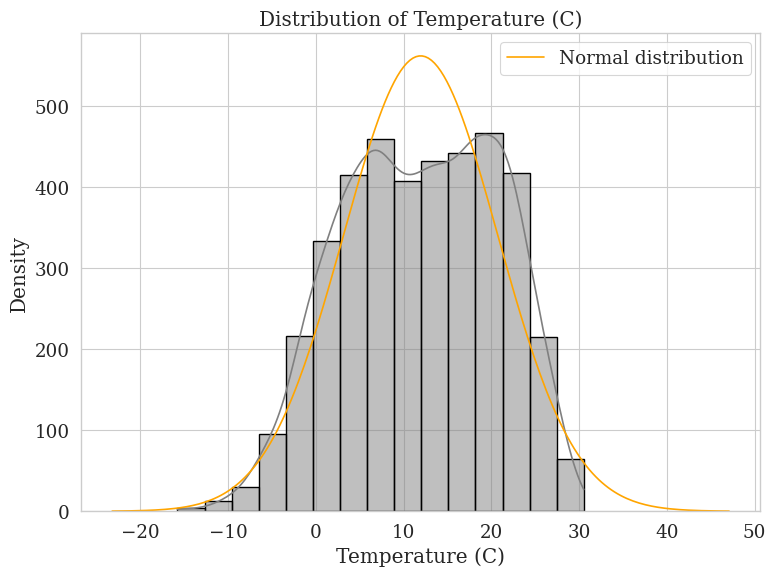

In [58]:
# Calculate the mean and standard deviation of the 'Temperature (C)' column
mean = temp_final['Temperature (C)'].mean()
std = temp_final['Temperature (C)'].std()

# Generate points on the x axis that cover the range of the temperature data
x_points = np.linspace(mean - 4*std, mean + 4*std, 200)

# Calculate the PDF of the normal distribution using the mean and standard deviation of the data
pdf = norm.pdf(x_points, mean, std)

# Determine the bin width to scale the normal distribution curve to the histogram
bin_width = (temp_final['Temperature (C)'].max() - temp_final['Temperature (C)'].min()) / 15

# Create figure and axis to control size and resolution
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

# Create density plot and histogram
sns.histplot(data=temp_final, x='Temperature (C)', kde=True, bins=15, color='gray', edgecolor='black', linewidth=1, ax=ax)

# Plot the normal distribution curve scaled appropriately
ax.plot(x_points, pdf * len(temp_final['Temperature (C)']) * bin_width, label='Normal distribution', color='orange')

# Adding grid lines
ax.grid(True)

# Customizing
ax.set_title('Distribution of Temperature (C)')
ax.set_xlabel('Temperature (C)')
ax.set_ylabel('Density')

# Adding legend to the plot
ax.legend()

plt.tight_layout()
plt.show()

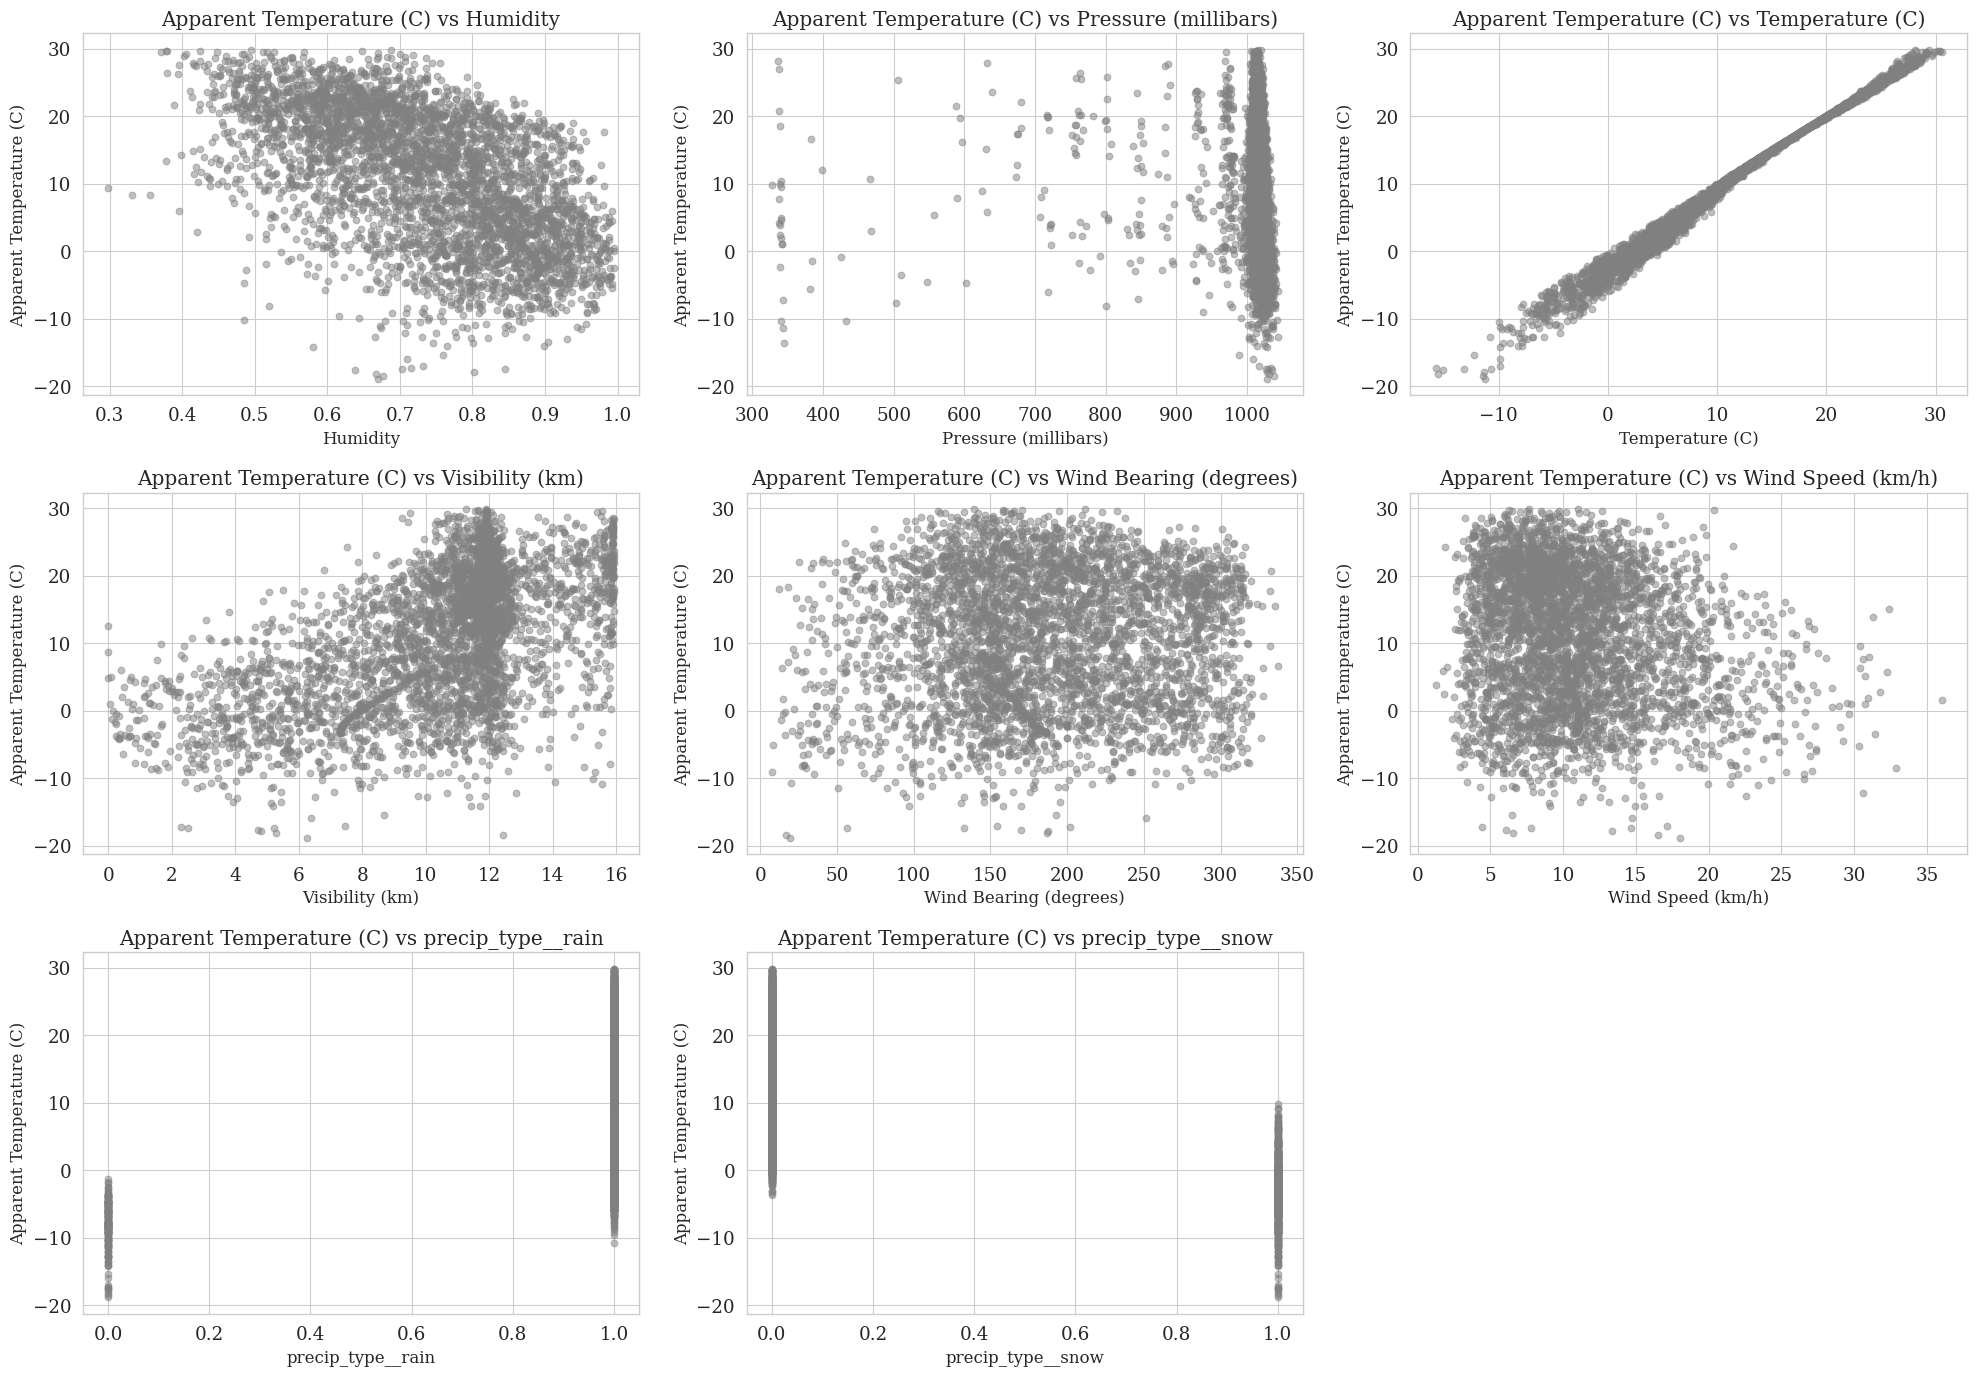

In [59]:
# Define target and predictors
target = 'Apparent Temperature (C)'
predictors = temp_final.drop([target], axis=1).columns

# Create a grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 14))
axs = axs.flatten()

# Create a scatter plot for each predictor
for i, predictor in enumerate(predictors):
    axs[i].scatter(temp_final[predictor], temp_final[target], alpha=0.5, color = "gray")
    axs[i].set_title(f'{target} vs {predictor}')
    axs[i].set_xlabel(predictor, fontsize = 12)
    axs[i].set_ylabel(target, fontsize = 12)

axs[-1].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Show plots
plt.show()

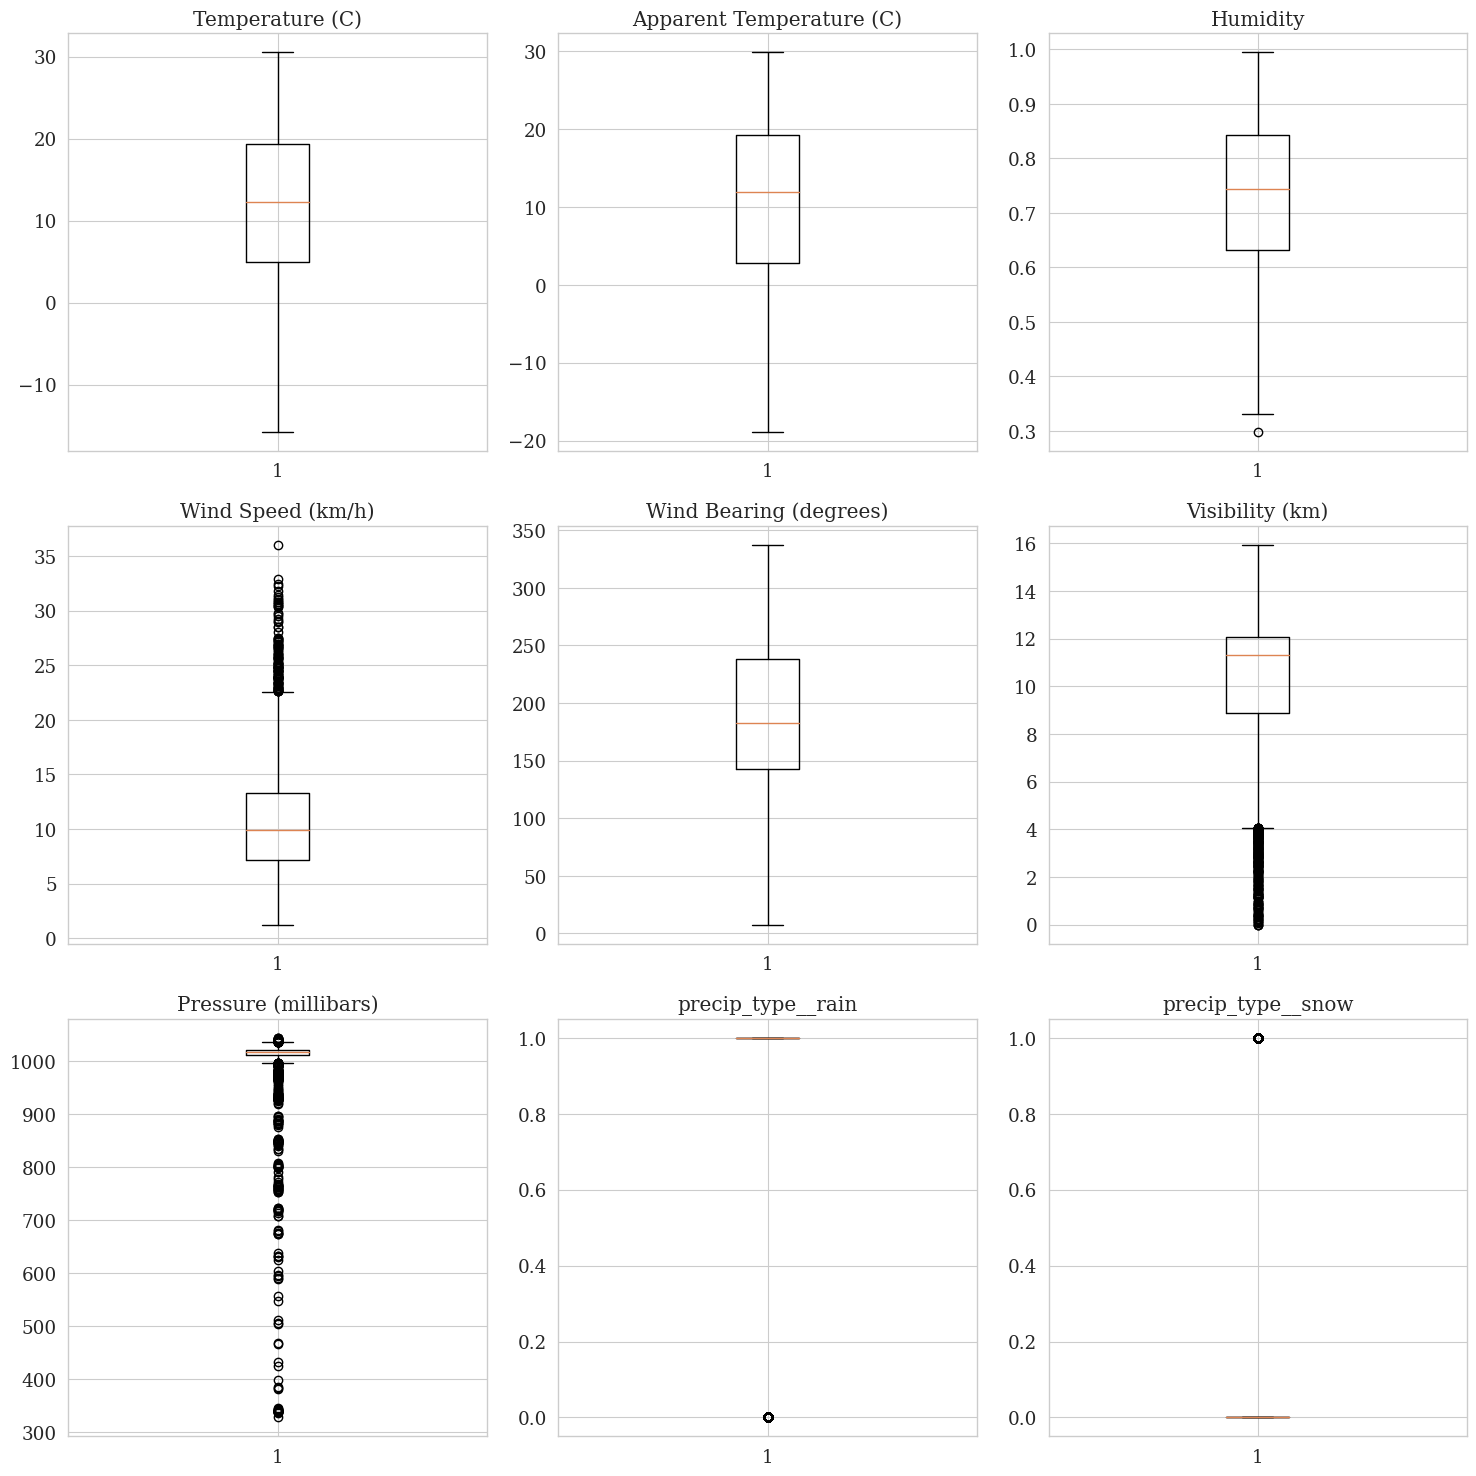

In [60]:
# Determine the number of rows and columns for the subplots
num_variables = len(temp_final.columns)
ncols = 3
nrows = (num_variables + ncols - 1) // ncols  # Calculates the required number of rows

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axs = axs.flatten()  # Flatten the array of axes

# Plotting boxplots for each column
for i, column in enumerate(df.columns):
    axs[i].boxplot(temp_final[column])
    axs[i].set_title(column)

# Hide any unused subplots
for i in range(num_variables, nrows * ncols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

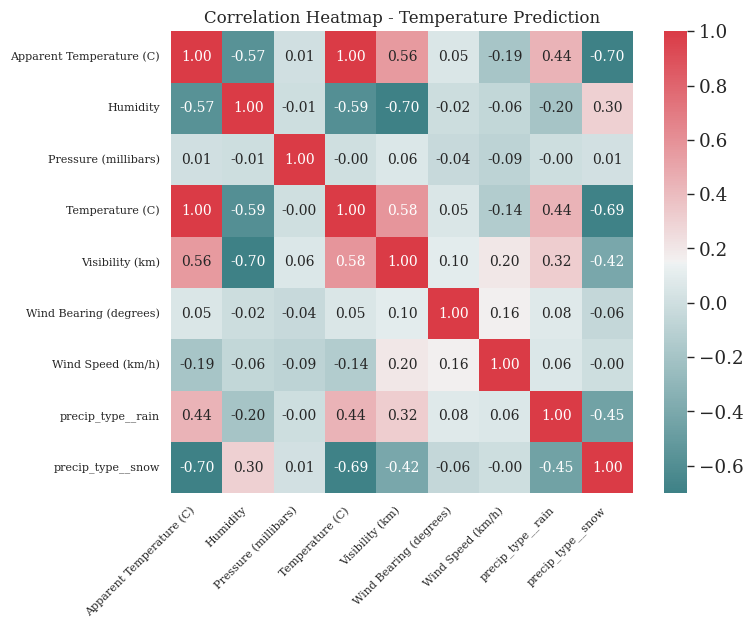

In [61]:
# Drop "Date" column from the dataframe as not needed for correlation heatmap
columns = temp_final.columns
correlation_df = temp_final[columns].corr()

# Initialize the matplotlib figure
fig, axs = plt.subplots(figsize=(8, 6))

# Generate heatmap using sns.heatmap-function
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap=sns.diverging_palette(200, 10, as_cmap=True),
            square=True, ax=axs, annot_kws={"size": 10})

# Adjust the plot for readability
plt.xticks(rotation=45, ha='right', fontsize = 8)
plt.yticks(rotation=0, fontsize = 8)
plt.title('Correlation Heatmap - Temperature Prediction', fontsize = 12)

# Show the plot
plt.show()

## 1.3 Create and visualize training and test-dataset

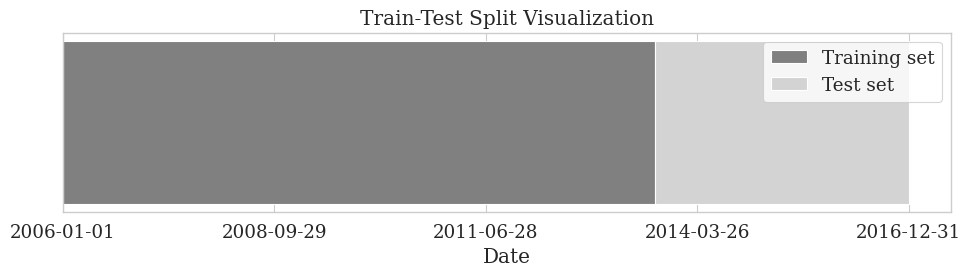

In [62]:
def plot_train_test_split(df, test_size=0.3):
    """
    Visualize a train-test split using horizontal bars with actual dates on the x-axis.

    :param df: DataFrame, the entire dataset with a datetime index.
    :param test_size: float, represents the proportion of the dataset to include in the test split.
    """
    # Ensure the DataFrame is sorted by its index
    df = df.sort_index()

    # Perform the split
    train_size = int((1 - test_size) * len(df))
    train_set = df.iloc[:train_size]
    test_set = df.iloc[train_size:]

    # Create a figure to visualize the split
    plt.figure(figsize=(10, 3))

    # Plot the training set
    plt.barh(y=1, width=len(train_set), left=0, color='gray', height=0.5, label='Training set')

    # Plot the test set, starting at the end of the training set
    plt.barh(y=1, width=len(test_set), left=len(train_set), color='lightgray', height=0.5, label='Test set')

    # Formatting the x-axis with actual dates
    plt.xlabel('Date')
    plt.yticks([])
    plt.title('Train-Test Split Visualization')
    plt.legend()

    # Convert the index to actual dates for plotting
    date_ticks = df.index
    plt.xticks(ticks=np.linspace(0, len(df), num=5),
               labels=[date_ticks[int(i)].strftime('%Y-%m-%d') for i in np.linspace(0, len(df)-1, num=5)])

    plt.tight_layout()
    plt.show()

    return train_set, test_set

# Call the function to visualize the train-test split with actual dates and adjusted bar height
training_set, test_set = plot_train_test_split(temp_final, test_size=0.3)

# 02 Modelling, Cross Validation and Prediction - GLM



In [63]:
# Reset indeces of training and test set to ensure correct TimeSeriesCrossValidation
training_set.sort_index (inplace=False)
test_set.sort_index(inplace=False)

# Create target and feature vector for training set
X_train = training_set.drop(["Temperature (C)"], axis=1)
y_train = training_set['Temperature (C)']

# Create target and feature vector for test set
X_test = test_set.drop(["Temperature (C)"], axis=1)
y_test = test_set['Temperature (C)']

In [64]:
# Add constant to X_train. This will serve as the intercept in the regression model
X_train = sm.add_constant(X_train)

# Create GLM with Poisson distribution and canonical link function
glm_gaussian_2 = sm.GLM(y_train, X_train[["const", "Visibility (km)", "Apparent Temperature (C)"]], family=sm.families.Gaussian())

# Fit the model and print model summary
glm_gaussian_results_2 = glm_gaussian_2.fit()
print(glm_gaussian_results_2.summary2())

                  Results: Generalized linear model
Model:                GLM                AIC:              6619.7130  
Link Function:        Identity           BIC:              -20519.6952
Dependent Variable:   Temperature (C)    Log-Likelihood:   -3306.9    
Date:                 2024-02-12 20:39   LL-Null:          -1.8960e+05
No. Observations:     2806               Deviance:         1734.8     
Df Model:             2                  Pearson chi2:     1.73e+03   
Df Residuals:         2803               Scale:            0.61890    
Method:               IRLS                                            
----------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|  [0.025 0.975]
----------------------------------------------------------------------
const                    1.3412   0.0576  23.2836 0.0000 1.2283 1.4541
Visibility (km)          0.1257   0.0064  19.5433 0.0000 0.1131 0.1383
Apparent Temperature (C) 

In [65]:
# Add constant to X_train. This will serve as the intercept in the feature vector
X_test = sm.add_constant(X_test)

# Make predictions
y_pred_gaussian = glm_gaussian_results_2.predict(X_test[["const", "Visibility (km)", "Apparent Temperature (C)"]])

# Calculate performance metrics (MSE, RMSE, MAE)
mse = mean_squared_error(y_test, y_pred_gaussian)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_gaussian)

# Print the results
print(f"Mean MSE: {mse:.3f}")
print(f"Mean RMSE: {rmse:.3f}")
print(f"Mean MAE: {mae:.3f}")

Mean MSE: 0.588
Mean RMSE: 0.767
Mean MAE: 0.599


In [66]:
# Add constant to X_train. This will serve as the intercept in the regression model
X_train = sm.add_constant(X_train)

# Create GLM with Poisson distribution and canonical link function
glm_gaussian_full = sm.GLM(y_train, X_train, family=sm.families.Gaussian())

# Fit the model and print model summary
glm_gaussian_results_full = glm_gaussian_full.fit()
print(glm_gaussian_results_full.summary2())

                    Results: Generalized linear model
Model:                 GLM                 AIC:               5611.5946  
Link Function:         Identity            BIC:               -21000.8067
Dependent Variable:    Temperature (C)     Log-Likelihood:    -2796.8    
Date:                  2024-02-12 20:39    LL-Null:           -2.7080e+05
No. Observations:      2806                Deviance:          1206.0     
Df Model:              8                   Pearson chi2:      1.21e+03   
Df Residuals:          2797                Scale:             0.43118    
Method:                IRLS                                              
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
const                     1.3260   0.2588   5.1240 0.0000  0.8188  1.8332
Apparent Temperature (C)  0.8971   0.0023 384.5772 0.0000 

In [67]:
# Calculate influence measures
influence_glm = glm_gaussian_results_full.get_influence()

# Obtain summary measures of influence
summaries = influence_glm.summary_frame()

# Cook's distance is one of the summary measures provided
cooks_d_glm = summaries['cooks_d']

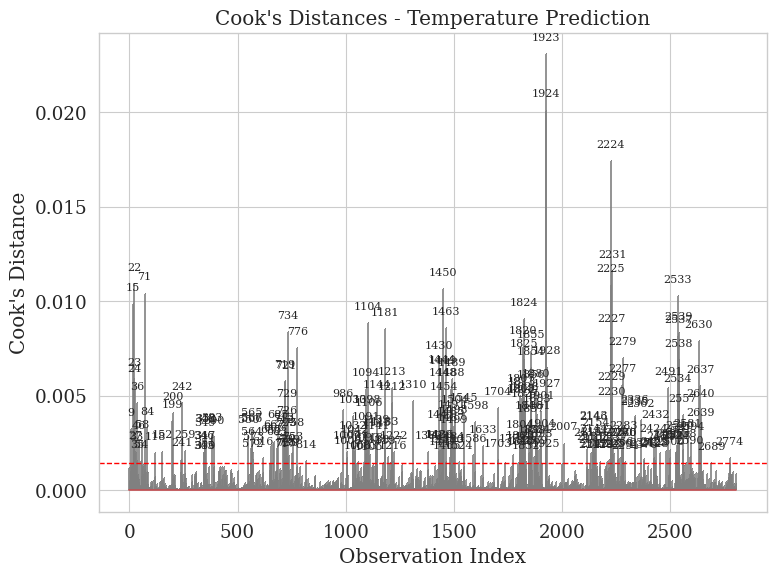

In [68]:
# Take a threshold of 4/N
threshold = 4/len(X_train)

# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.stem(np.arange(len(cooks_d_glm)), cooks_d_glm, markerfmt=',', use_line_collection=True, linefmt='gray')

# Setting the title and labels
ax.set_title('Cook\'s Distances - Temperature Prediction')
ax.set_xlabel('Observation Index')
ax.set_ylabel('Cook\'s Distance')

# Adding a horizontal line for the Cook's distance threshold
ax.axhline(y=threshold, ls='--', c='red', linewidth=1)

# Adding grid lines
ax.grid(True)

# Annotate the points above the threshold
for i, cd in enumerate(cooks_d_glm):
    if cd > threshold:
        ax.annotate(f"{i}", (i, cd), textcoords="offset points", xytext=(0,10), ha='center', size = 8)

plt.tight_layout()
plt.show()

In [69]:
# Identify all points where Cook's distance is above the threshold
influential_points = cooks_d_glm > threshold

# Create an array of indices for influential points
influential_indices = np.where(influential_points)[0]

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

size_before = len(X_train)

# Now try to drop the rows by index
X_train = X_train.drop(index=influential_indices)
y_train = y_train.drop(index=influential_indices)

print("Removed Outliers:", size_before-len(X_train))

Removed Outliers: 224


In [70]:
# Add constant to X_train. This will serve as the intercept in the regression model
X_train = sm.add_constant(X_train)

# Create GLM with Poisson distribution and canonical link function
glm_gaussian_final = sm.GLM(y_train, X_train, family=sm.families.Gaussian())

# Fit the model and print model summary
glm_gaussian_results_final = glm_gaussian_final.fit()
print(glm_gaussian_results_final.summary2())

                    Results: Generalized linear model
Model:                 GLM                 AIC:               4110.0449  
Link Function:         Identity            BIC:               -19476.8016
Dependent Variable:    Temperature (C)     Log-Likelihood:    -2046.0    
Date:                  2024-02-12 20:39    LL-Null:           -3.3441e+05
No. Observations:      2582                Deviance:          737.51     
Df Model:              8                   Pearson chi2:      738.       
Df Residuals:          2573                Scale:             0.28663    
Method:                IRLS                                              
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
const                     1.5121   0.2500   6.0492 0.0000  1.0222  2.0020
Apparent Temperature (C)  0.9003   0.0020 453.8711 0.0000 

In [71]:
# Create arrays for performance metrics per fold
mse_fold, rmse_fold, mae_fold = [], [], []

# Create TimeSeriesSplit for time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform time series cross-validation
for train_index, test_index in tscv.split(X_train):

    # Split the data into training and test sets for the current fold
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Add a constant to the model (if you're using statsmodels, it doesn't add a constant by default)
    X_train_fold = sm.add_constant(X_train_fold)
    X_test_fold = sm.add_constant(X_test_fold)

    # Define the GLM model with the Negative Binomial family and fit it to the training data
    glm_gaussian = sm.GLM(y_train_fold, X_train_fold, family=sm.families.Gaussian())
    glm_gaussian_results = glm_gaussian.fit()

    # Now you can use glm_results to make predictions and evaluate the model
    y_pred = glm_gaussian_results.predict(X_test_fold)

    # Evaluate the model performance using MSE, RMSE, MAE
    mse = mean_squared_error(y_test_fold, y_pred)
    mse_fold.append(mse)
    rmse = np.sqrt(mse)
    rmse_fold.append(rmse)
    mae = mean_absolute_error(y_test_fold, y_pred)
    mae_fold.append(mae)

# Print the results
print(f"Mean MSE: {np.mean(mse_fold):.3f}")
print(f"Mean RMSE: {np.mean(rmse_fold):.3f}")
print(f"Mean MAE: {np.mean(mae_fold):.3f}")

Mean MSE: 0.302
Mean RMSE: 0.549
Mean MAE: 0.448


In [72]:
# Refit final model with complete training data
glm_gaussian_results = sm.GLM(y_train, X_train, family=sm.families.Gaussian()).fit()

In [73]:
# Adding a constant to the predictor variable set in the test set for statsmodels
X_test_sm = sm.add_constant(X_test)

# Predicting the test set using the last trained GLM model
y_test_pred_glm = glm_gaussian_results.predict(X_test_sm)

#Calculate Mean squared error for prediction on test set
mse_test_glm = mean_squared_error(y_test, y_test_pred_glm)
mae_test_glm = mean_absolute_error(y_test, y_test_pred_glm)

print("MSE for prediction:", mse_test_glm)
print("RMSE for prediction:", np.sqrt(mse_test_glm))
print("MAE for prediction:", mae_test_glm)

MSE for prediction: 0.3946678587819454
RMSE for prediction: 0.6282259615631508
MAE for prediction: 0.5020200657269395


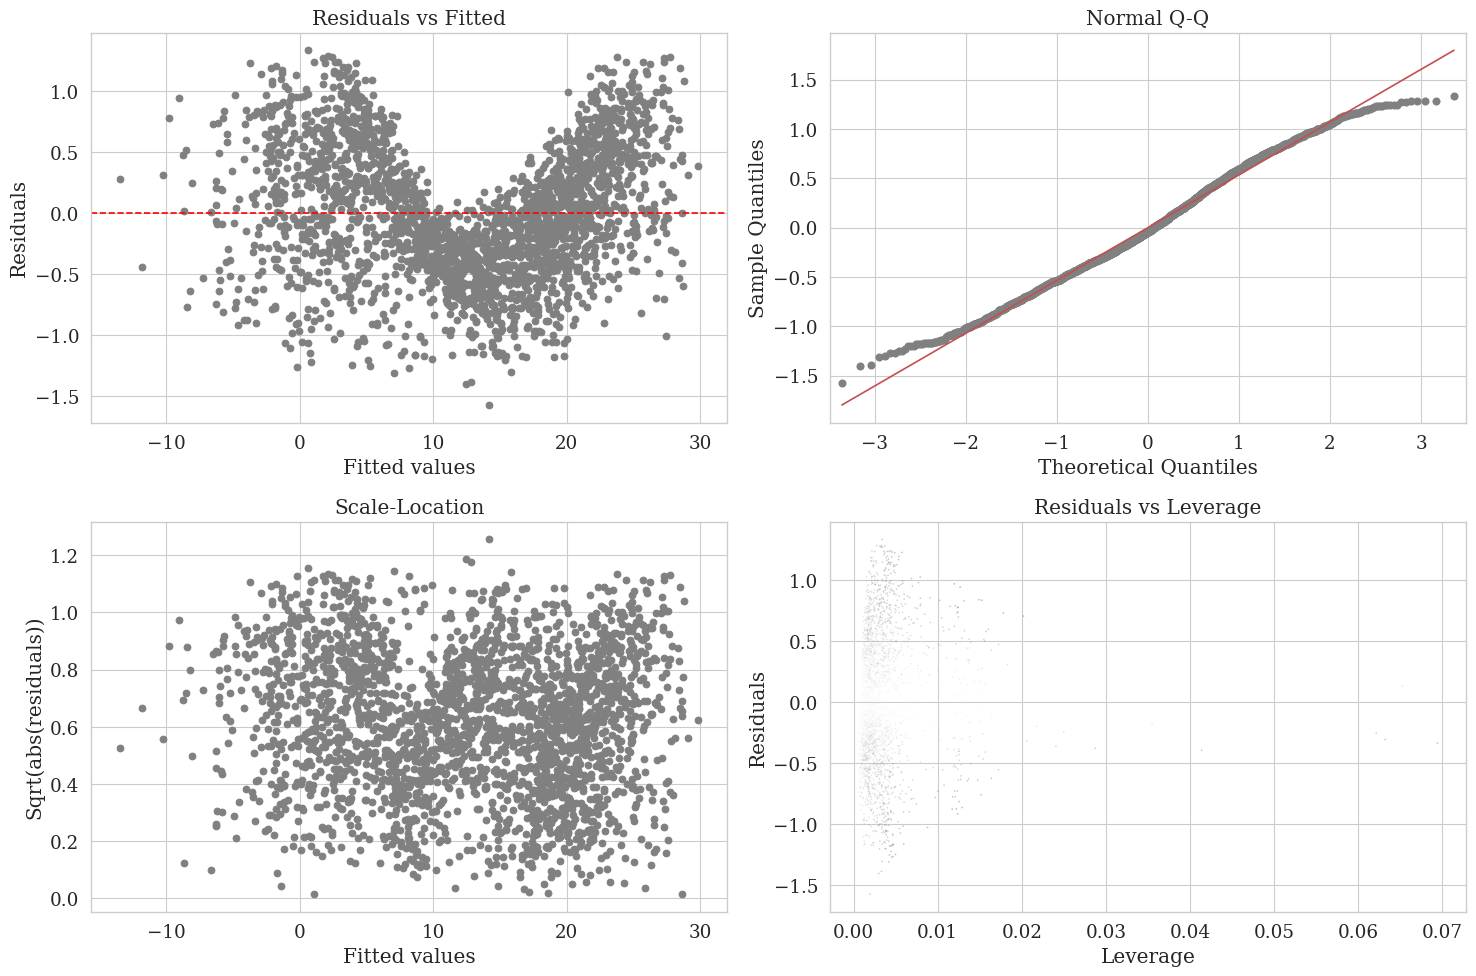

In [74]:
# Create diagnostic plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Residuals vs Fitted
axs[0, 0].scatter(glm_gaussian_results.fittedvalues, glm_gaussian_results.resid_response, color = "gray")
axs[0, 0].axhline(0, color='red', linestyle='--')
axs[0, 0].set_title('Residuals vs Fitted')
axs[0, 0].set_xlabel('Fitted values')
axs[0, 0].set_ylabel('Residuals')

# Normal Q-Q
sm.qqplot(glm_gaussian_results.resid_response, line='s', ax=axs[0, 1], markeredgecolor='gray', markerfacecolor='gray')
axs[0, 1].set_title('Normal Q-Q')

# Scale-Location
axs[1, 0].scatter(glm_gaussian_results.fittedvalues, np.sqrt(np.abs(glm_gaussian_results.resid_response)), color = "gray")
axs[1, 0].set_title('Scale-Location')
axs[1, 0].set_xlabel('Fitted values')
axs[1, 0].set_ylabel('Sqrt(abs(residuals))')

# Residuals vs Leverage
# We will use the cooks distance as a measure for the leverage plot
influence = glm_gaussian_results.get_influence()
cooks = influence.cooks_distance[0]
leverage = influence.hat_matrix_diag
axs[1, 1].scatter(leverage, glm_gaussian_results.resid_response, s=50 * cooks, alpha=0.5, color = "gray")
axs[1, 1].set_title('Residuals vs Leverage')
axs[1, 1].set_xlabel('Leverage')
axs[1, 1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

# 03 Modelling, Cross Validation and Prediction - Random Forest


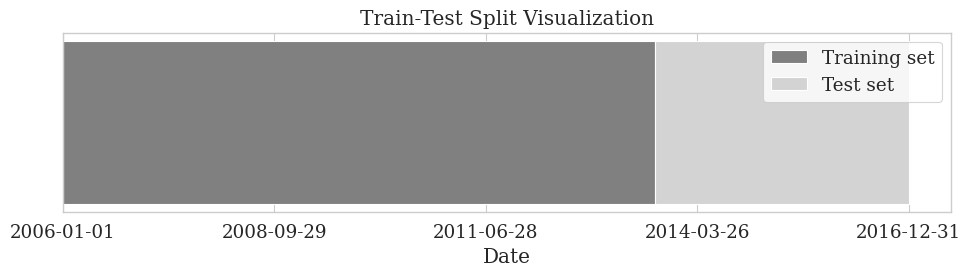

In [77]:
training_set, test_set = plot_train_test_split(temp_final, test_size=0.3)

In [78]:
# Reset indeces of training and test set to ensure correct TimeSeriesCrossValidation
training_set.sort_index (inplace=False)
test_set.sort_index(inplace=False)

# Create target and feature vector for training set
X_train = training_set.drop(["Temperature (C)"], axis=1)
y_train = training_set['Temperature (C)']

# Create target and feature vector for test set
X_test = test_set.drop(["Temperature (C)"], axis=1)
y_test = test_set['Temperature (C)']

In [79]:
# Fit a base model using standard settings for hyperparameters
rf_basemodel = RandomForestRegressor(random_state=42)
rf_basemodel.fit(X_train, y_train)

# Make first predictions
y_pred_rf = rf_basemodel.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rf)

# Print performance metrics
print(f"Mean MSE: {mse:.3f}")
print(f"Mean RMSE: {rmse:.3f}")
print(f"Mean MAE: {mae:.3f}")

Mean MSE: 0.052
Mean RMSE: 0.228
Mean MAE: 0.150


In [80]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 1, 2, 3, 4, 5, 6, 7, 8]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10, 15, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt', 1, 2, 3, 4, 5, 6, 7, 8],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10, 15, 20],
 'min_samples_leaf': [2, 5, 10, 15, 20],
 'bootstrap': [True, False]}

In [ ]:
# Define TimeSeriesSplit for Cross-Validation performed by RandomizedSearchCV
tscv = TimeSeriesSplit(n_splits=5)

# Create RandomizedSearchCV with basemodel, defined parameter grid and use 5-fold Cross-Validation
# "n_iter" represents the number of iterations to find best hyperparameters. Will be set to 100 due to time limitations
rf_random = RandomizedSearchCV(estimator = rf_basemodel, param_distributions = random_grid, n_iter = 100, cv = tscv,
                               verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 1, 2,
                                                         3, 4, 5, 6, 7, 8],
                                        'min_samples_leaf': [2, 5, 10, 15, 20],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
# Display best parameters found by RandomizedSearchCV
print(rf_random.best_params_)

{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 7, 'max_depth': 60, 'bootstrap': True}


In [81]:
# Based on the results of the RandomizedSearchCV, the parameter space could be reduced to a range of candidates for best hyperparameters
# Parameter grid for GridSearchCV is based on results of the RandomizedSearchCV. Ranges for the different hyperparameters were adjusted around the best parameters found by the RandomizedSearchCV

# Define the parameter grid to search
param_grid = {'n_estimators': [500, 550, 600, 650, 700],
               'max_features': [6,7,8],
               'max_depth': [50, 60, 70],
               'min_samples_split': [1,2,3],
               'min_samples_leaf': [1,2,3],
               'bootstrap': [True]}

# Create the base model to tune
rf = RandomForestRegressor(random_state=42)

# Define scoring function using MSE as criterion
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Create RandomizedSearchCV with basemodel, defined parameter grid and cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=tscv, n_jobs=-1, scoring=scorer, verbose=2)

# Fit grid search to training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [50, 60, 70],
                         'max_features': [6, 7, 8],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [500, 550, 600, 650, 700]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False),
             verbose=2)

In [82]:
# Display best parameters found by GridSearchCV
print(grid_search.best_params_)

{'bootstrap': True, 'max_depth': 50, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}


In [83]:
#Specify best model according to grid search results
rf_best = RandomForestRegressor(
    random_state = 42,
    n_estimators= 600,
    min_samples_leaf= 1,
    min_samples_split = 2,
    max_features = 7,
    max_depth = 50,
    bootstrap = True
)

In [84]:
# Create arrays for performance metrics per fold
mse_fold, rmse_fold, mae_fold = [], [], []

# Create TimeSeriesSplit for time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform time series cross-validation
for train_index, test_index in tscv.split(X_train):

    # Split the data into training and test sets for the current fold
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    rf_best.fit(X_train_fold, y_train_fold)

    # Now you can use glm_results to make predictions and evaluate the model
    y_pred = rf_basemodel.predict(X_test_fold)

    # Evaluate the model performance using MSE, RMSE, MAE
    mse = mean_squared_error(y_test_fold, y_pred)
    mse_fold.append(mse)
    rmse = np.sqrt(mse)
    rmse_fold.append(rmse)
    mae = mean_absolute_error(y_test_fold, y_pred)
    mae_fold.append(mae)

# Print the results
print(f"Mean MSE: {np.mean(mse_fold):.3f}")
print(f"Mean RMSE: {np.mean(rmse_fold):.3f}")
print(f"Mean MAE: {np.mean(mae_fold):.3f}")

Mean MSE: 0.009
Mean RMSE: 0.093
Mean MAE: 0.057


In [85]:
#Specify best model according to grid search results
rf_best = RandomForestRegressor(
    random_state = 42,
    n_estimators= 600,
    min_samples_leaf= 1,
    min_samples_split = 2,
    max_features = 7,
    max_depth = 50,
    bootstrap = True
)
rf_best.fit(X_train, y_train)

# Make first predictions
y_pred_RF = rf_best.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred_RF)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_RF)

# Print performance metrics
print(f"Mean MSE: {mse:.3f}")
print(f"Mean RMSE: {rmse:.3f}")
print(f"Mean MAE: {mae:.3f}")

Mean MSE: 0.050
Mean RMSE: 0.223
Mean MAE: 0.148


# 04 Comparison of results

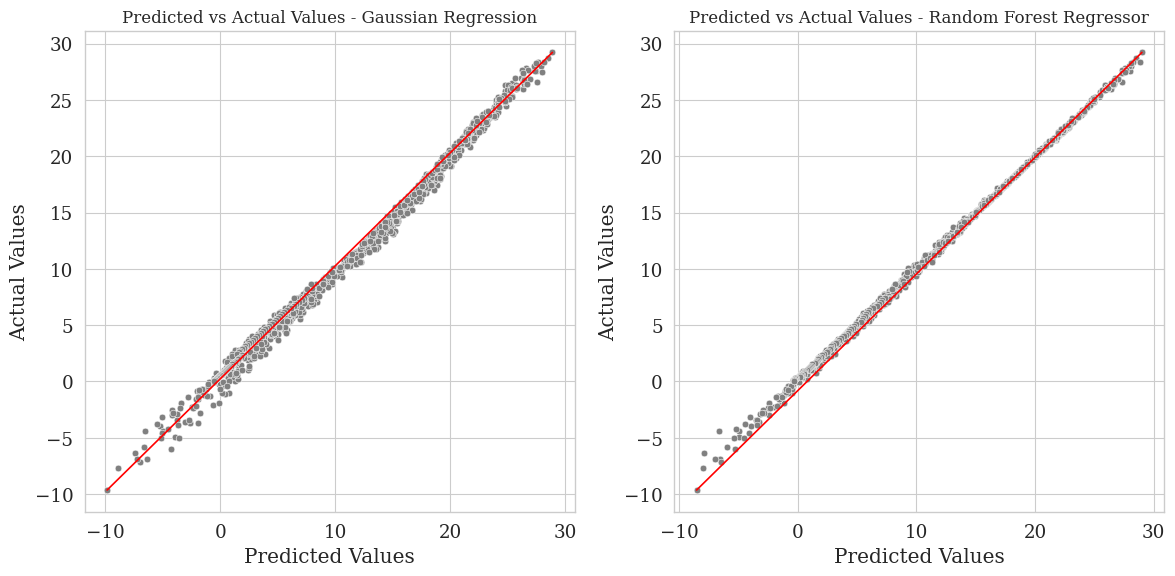

In [86]:
# Initialize pyplot figure
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Create Actuals vs. Predictions Scatterplot for predictions made by Random Forest
sns.scatterplot(x=y_pred_RF, y=y_test, ax=axs[1], color='gray')
# Optical adjustments (X/Y-Lables, Title, Line of perfect prediction)
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Actual Values')
axs[1].set_title('Predicted vs Actual Values - Random Forest Regressor', fontsize=12)
axs[1].plot([min(y_pred_RF), max(y_pred_RF)], [min(y_test), max(y_test)], color='red')  # line of perfect prediction
axs[1].grid(True)

# Create Actuals vs. Predictions Scatterplot for predictions made by GLM
sns.scatterplot(x=y_test_pred_glm, y=y_test, ax=axs[0], color='gray')
# Optical adjustments (X/Y-Lables, Title, Line of perfect prediction)
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Actual Values')
axs[0].set_title('Predicted vs Actual Values - Gaussian Regression', fontsize=12)
axs[0].plot([min(y_test_pred_glm), max(y_test_pred_glm)], [min(y_test), max(y_test)], color='red')  # line of perfect prediction
axs[0].grid(True)

# Adjust the layout
plt.tight_layout()

# Show plot
plt.show()

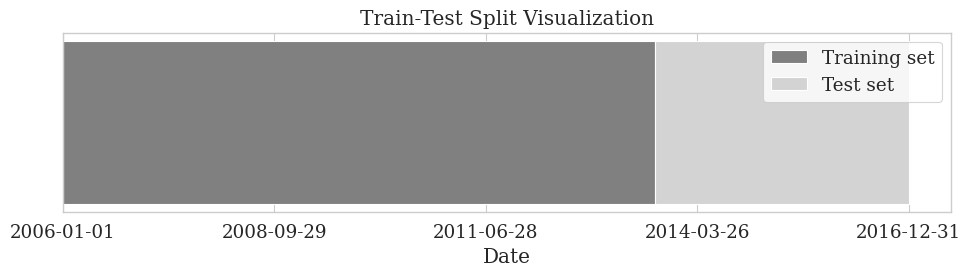

In [87]:
# Re-create identical test set for plotting
training_set, test_set = plot_train_test_split(temp_final, test_size=0.3)

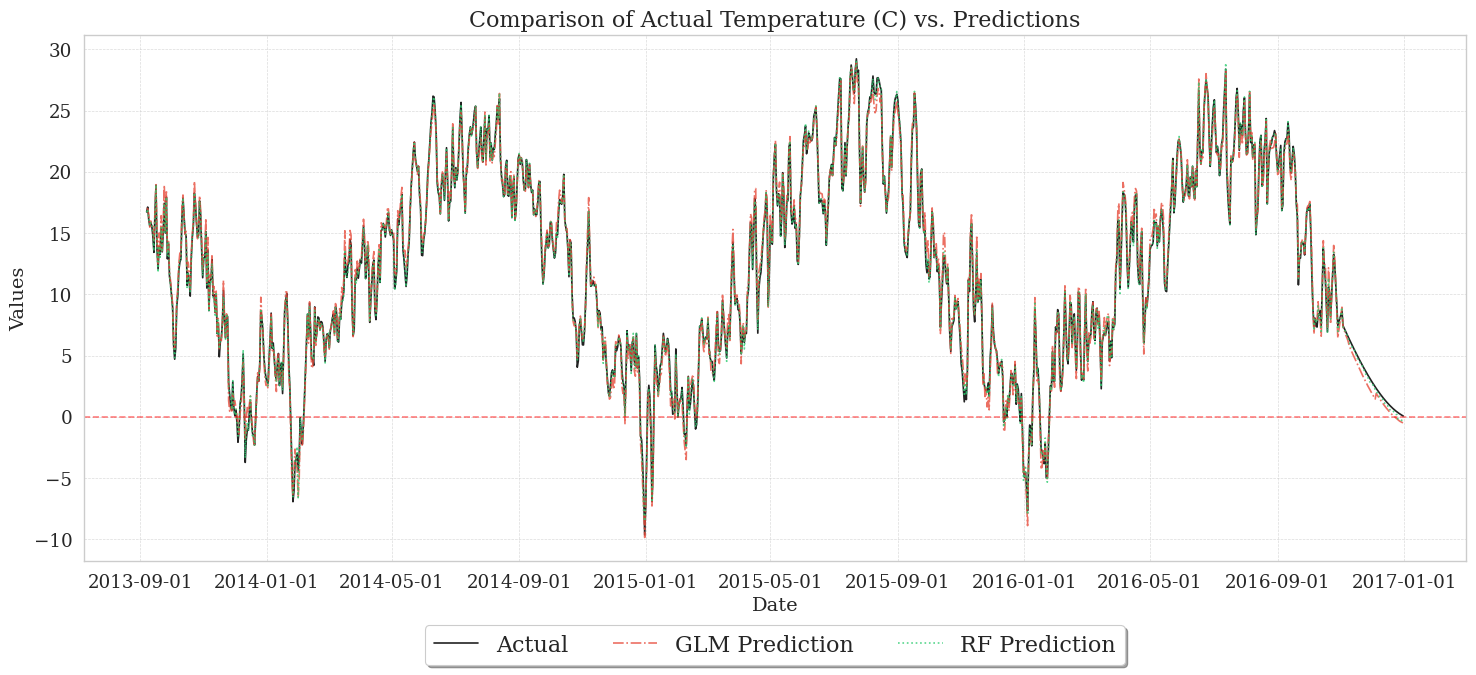

In [88]:
# Add predictions made by both models to the test set
test_set["Predicted_RF"] = y_pred_RF
test_set["Predicted_GLM"] = y_test_pred_glm

# Intialize pylot figure
plt.figure(figsize=(15, 7))

# Plot actual values with larger markers
plt.plot(test_set.index, test_set['Temperature (C)'], label='Actual', color='#222222', markersize=8)

# Plot GLM predictions with a distinct line style and marker
plt.plot(test_set.index, test_set['Predicted_GLM'], label='GLM Prediction', color='#e74c3c', linestyle='-.', markersize=8, alpha = 0.8)

# Plot Random Forest predictions with a different line style and marker
plt.plot(test_set.index, test_set['Predicted_RF'], label='RF Prediction', color='#2ecc71', linestyle=':', markersize=8, alpha = 0.8)

# Adjust Lables and Title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Comparison of Actual Temperature (C) vs. Predictions', fontsize=16)

# Format the date axis to prevent overlapping and improve readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Make gridlines lighter
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Place the legend outside the plot to avoid covering data points
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=3, prop={'size': 16})

# Draw a horizontal zero line
plt.axhline(0, color='red', linestyle='--', alpha=0.5)

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()

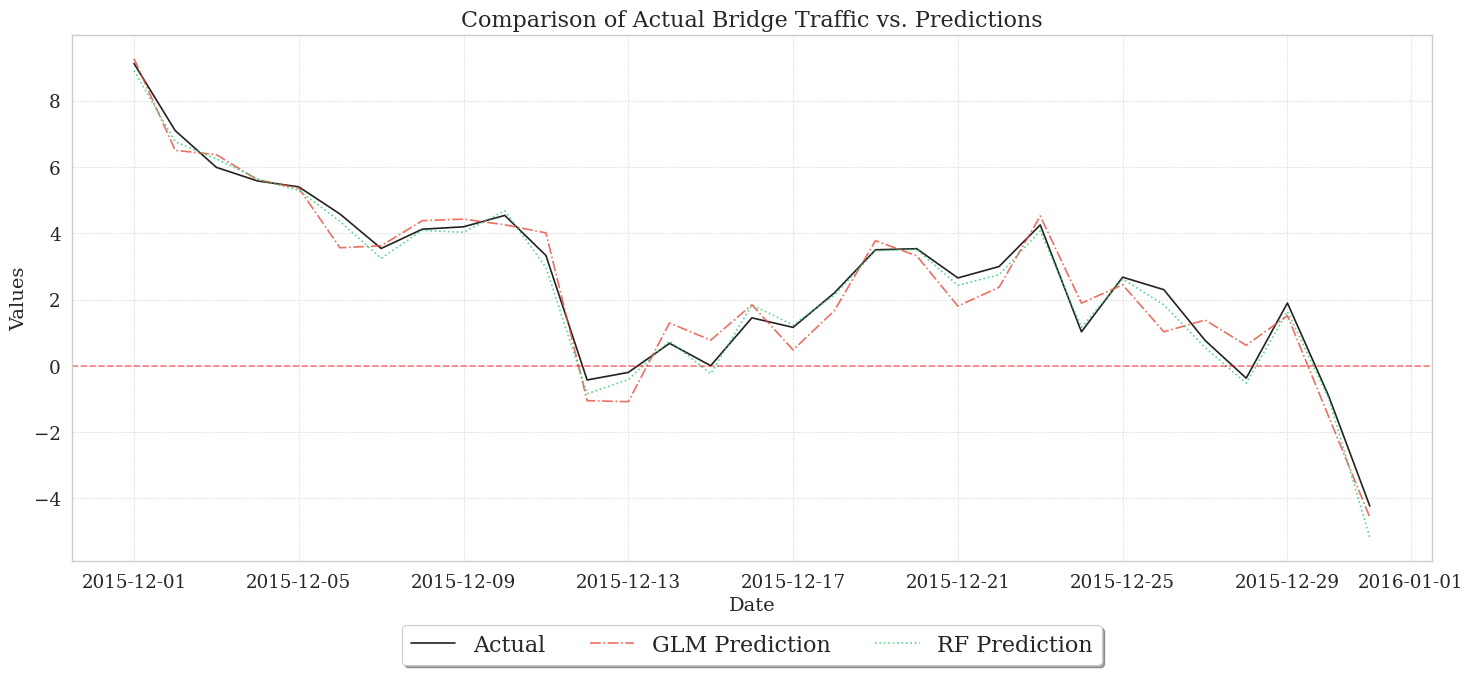

In [89]:
# Filter for December 2015
test_set = test_set['2015-12']

# Intialize pylot figure
plt.figure(figsize=(15, 7))

# Plot actual values with larger markers
plt.plot(test_set.index, test_set['Temperature (C)'], label='Actual', color='#222222', markersize=8)

# Plot GLM predictions with a distinct line style and marker
plt.plot(test_set.index, test_set['Predicted_GLM'], label='GLM Prediction', color='#e74c3c', linestyle='-.', markersize=8, alpha = 0.8)

# Plot Random Forest predictions with a different line style and marker
plt.plot(test_set.index, test_set['Predicted_RF'], label='RF Prediction', color='#2ecc71', linestyle=':', markersize=8, alpha = 0.8)

# Adjust Lables and Title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Comparison of Actual Bridge Traffic vs. Predictions', fontsize=16)

# Format the date axis to prevent overlapping and improve readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Make gridlines lighter
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Place the legend outside the plot to avoid covering data points
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=3, prop={'size': 16})

# Draw a horizontal zero line
plt.axhline(0, color='red', linestyle='--', alpha=0.5)

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()

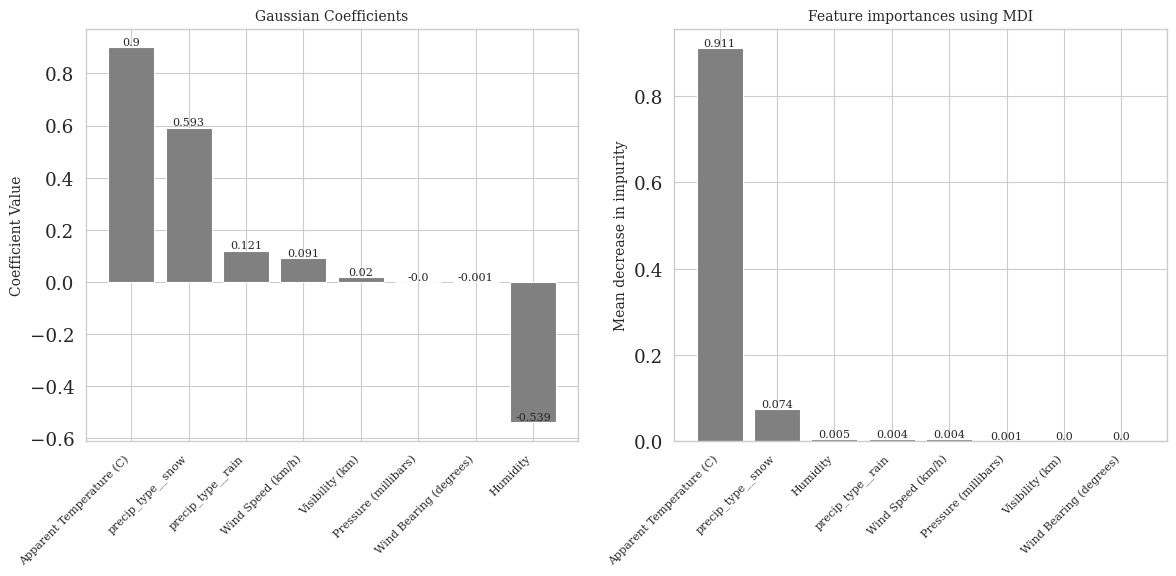

In [90]:
# Get feature importances from Random Forest
importances = rf_best.feature_importances_

# Add importances and corresponding column names to a dataframe
forest_importances = pd.Series(importances, X_train.columns).sort_values(ascending=False)

# Get coefficients from Negative Binomial model
gamma_coefficients = glm_gaussian_results.params[1:]  # Exclude intercept
gamma_coefficients = pd.Series(gamma_coefficients, index=glm_gaussian_results.model.exog_names[1:]).sort_values(ascending=False)

# Initialize pyplot figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Random Forest feature importances
bars_rf = axs[1].bar(forest_importances.index, forest_importances, color = "gray")
axs[1].set_title("Feature importances using MDI", fontsize=10)
axs[1].set_ylabel("Mean decrease in impurity", fontsize=10)
axs[1].set_xticklabels(forest_importances.index, rotation = 45, ha="right", fontsize=8)


# Add the actual numbers on top of each bar, centered (Random Forest)
for bar in bars_rf:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), va='bottom', ha='center', fontsize=8)

# Plot Negative Binomial coefficients
bars_nb = axs[0].bar(gamma_coefficients.index, gamma_coefficients, color = "gray")
axs[0].set_title("Gaussian Coefficients", fontsize=10)
axs[0].set_ylabel("Coefficient Value", fontsize=10)
axs[0].set_xticklabels(gamma_coefficients.index, rotation = 45, ha="right", fontsize=8)

# Add the actual numbers on top of each bar, centered (Negative Binomial)
for bar in bars_nb:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), va='bottom', ha='center', fontsize=8)

# Adjust layout
fig.tight_layout()

# Show plot
plt.show()